# Calculating the ***S***ecular ***H***eritability ***EST***imate (SHEST)



### Import Statements

In [2]:
import gspread
import os
import pylab
import math

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
from google.colab import files
from scipy.optimize import curve_fit
from numpy.linalg import lstsq
from google.colab import drive

### Access Data

For information on how the csv files should be formatted, see the README.md file in https://github.com/relhajj/SHEST-heritability.

In [ ]:
# mount google drive
drive.mount('/gdrive')

In [ ]:
# change directory to where the csvs are kept
# %cd /gdrive/Shared drives/SHEST Project/Data/csvs
%cd /gdrive/My Drive/SHEST Heritability/csvs

### Function Definitions

In [72]:
def fit_line(phenotype, header, ylabel, adj):
    # guide: fit_line(column name as found in dataframe,
    #                 graph title (phenotype name),
    #                 data description (e.g., Incidence / 100000),
    #                 y axis maximum adjustment to make graph look better)

    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    eqn_slope = np.polyfit(xdata, ydata, 1)

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print("Equation: %.3fx + %.3f"%(eqn_slope[0], eqn_slope[1]), "\n")

    print("H_min: %.3f" % min(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1]))
    print("H_max: %.3f" % max(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1]))

    print(header + " H^2: %.3f" % (min(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1])/max(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1])))
    print()

    ax = plt.figure(figsize=(8,5), edgecolor='black', facecolor='white').gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # for black figure border
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50

    plt.scatter(xdata, ydata, label='data', c='black', edgecolors='black')
    plt.title(header)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.ylim(ymin=0, ymax=max(ydata)+adj)

    plt.plot(xdata, [x*eqn_slope[0]+eqn_slope[1] for x in xdata], color="black")
    plt.show()

    return eqn_slope

def fit_line_custom_start(phenotype, header, ylabel, adj, start):
    # guide: fit_line(column name as found in dataframe,
    #                 graph title (phenotype name),
    #                 data description (e.g., Incidence / 100000),
    #                 y axis maximum adjustment to make graph look better),
    #                 y axis start to make graph look better

    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    eqn_slope = np.polyfit(xdata, ydata, 1)

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print("Equation: %.3fx + %.3f"%(eqn_slope[0], eqn_slope[1]), "\n")

    print("H_min: %.3f" % min(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1]))
    print("H_max: %.3f" % max(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1]))

    print(header + " H^2: %.3f" % (min(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1])/max(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1])))
    print()

    ax = plt.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.scatter(xdata, ydata, label='data')
    plt.title(header)
    plt.xlabel("Year")
    plt.ylabel(header+" "+ylabel)

    # Figure border
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50

    plt.ylim(ymin=start, ymax=max(ydata)+adj)
    plt.plot(xdata, [x*eqn_slope[0]+eqn_slope[1] for x in xdata], color="black")
    plt.show()

    return eqn_slope

def fit_test(phenotype):
    # guide: fit_line(column name as found in dataframe,
    #                 graph title (phenotype name),
    #                 data description (e.g., Incidence / 100000),
    #                 y axis maximum adjustment to make graph look better)

    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    eqn_slope = np.polyfit(xdata, ydata, 1)

    ax = plt.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.scatter(xdata, ydata, c='black')
    plt.ylim(ymin=0, ymax=(max(ydata)+min(ydata)))
    plt.show()

    return eqn_slope

def sigmoid(x, L ,x0, k, b):
    # Sigmoid Equation
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

def fit_sigmoid_example(phenotype, header, ylabel, adj):
    # guide: fit_sigmoid(column name as found in dataframe,
    #                    graph title (phenotype name),
    #                    data description (e.g., Incidence / 100000),
    #                    y axis maximum adjustment to make graph look better)

    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    p0 = [max(ydata), np.median(xdata),1,min(ydata)]
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print("Equation: %.3f / (1 + e^(-%.3f*(x - %.3f))) + %.3f" % (popt[0], popt[1], popt[2], popt[3]), "\n")

    print("H_min: %.3f" % min(popt[3], (popt[0]+popt[3])))
    print("H_max: %.3f" % max(popt[3], (popt[0]+popt[3])))

    print(header + " H^2: %.3f" % (min(popt[3]/(popt[0]+popt[3]),(popt[0]+popt[3])/popt[3])))
    print()

    x = np.linspace(min(xdata), max(xdata))
    y = sigmoid(x, *popt)

    ax = pylab.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # for black figure border
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50

    plt.title(header)
    pylab.xlabel("Year")

    pylab.ylabel(ylabel)
    plt.ylim(ymin=0, ymax=(max(ydata)+adj))

    pylab.plot(xdata, ydata, 'o', color='black')
    pylab.plot(x, y, color='black')

    xmin = min(xdata)
    xmax = max(xdata)
    ymax= max(ydata)+adj
    ax.axis([xmin, xmax, 0, ymax])
    ax.text(0, 10, r'Minimum', fontsize=15)

    pylab.show()

    return popt

def fit_sigmoid(phenotype, header, ylabel, adj):
    # guide: fit_sigmoid(column name as found in dataframe,
    #                    graph title (phenotype name),
    #                    data description (e.g., Incidence / 100000),
    #                    y axis maximum adjustment to make graph look better)

    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    p0 = [max(ydata), np.median(xdata),1,min(ydata)]
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print("Equation: %.3f / (1 + e^(-%.3f*(x - %.3f))) + %.3f" % (popt[0], popt[1], popt[2], popt[3]), "\n")

    print("H_min: %.3f" % min(popt[3], (popt[0]+popt[3])))
    print("H_max: %.3f" % max(popt[3], (popt[0]+popt[3])))

    print(header + " H^2: %.3f" % (min(popt[3]/(popt[0]+popt[3]),(popt[0]+popt[3])/popt[3])))
    print()

    x = np.linspace(min(xdata), max(xdata))
    y = sigmoid(x, *popt)

    ax = pylab.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # for black figure border
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50

    plt.title(header)
    pylab.xlabel("Year")

    pylab.ylabel(ylabel)

    plt.ylim(ymin=0, ymax=(max(ydata)+adj))

    pylab.plot(xdata, ydata, 'o', color='black')
    pylab.plot(x, y, color='black')
    pylab.show()

    return popt

ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 10

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0]

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution)
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    return Xsolution, Ysolution

def fit_segmented(phenotype, header, ylabel, adj, initialBreakpoints):
    # guide: fit_segmented(column name as found in dataframe,
    #                      graph title (phenotype name),
    #                      data description (e.g., Incidence / 100000),
    #                      y axis maximum adjustment to make graph look better,
    #                      list of years where the data seems to change)

    # get data

    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    x_sol, y_sol = SegmentedLinearReg(xdata, ydata, initialBreakpoints)

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    min_y_sol = min(y_sol)
    if min_y_sol < 0.0:
      min_y_sol = 0.0

    print("H_min: %.3f" % min_y_sol)
    print("H_max: %.3f" % max(y_sol))

    print(header + " H^2: %.3f" % (min_y_sol/max(y_sol)))
    print()

    ax = plt.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.plot(xdata, ydata, 'o', color='black')
    plt.xlabel("Year")
    plt.ylabel(ylabel)

    # Figure border
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50

    plt.title(header)
    plt.ylim(ymin=0, ymax=(max(ydata)+min(ydata)+adj))
    plt.plot( *SegmentedLinearReg(xdata, ydata, initialBreakpoints ), '-', color="black")

    return SegmentedLinearReg(xdata, ydata, initialBreakpoints)

def minmax_time(phenotype, header, ylabel, xlabel, adj):
    # guide: minmax_time(column name as found in dataframe,
    #                    graph title (phenotype name),
    #                    y-axis data description (e.g., Incidence / 100000),
    #                    x-axis data description (e.g., Year),
    #                    y axis maximum adjustment to make graph look better)

    xdata = [i for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    if min(xdata).isdigit() and max(xdata).isdigit():
      print("Min year:", int(min(xdata)))
      print("Max year:", int(max(xdata)), "\n")
    else:
      print("Min year:", min(xdata))
      print("Max year:", max(xdata), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print(header + " H^2: %.3f" % (min(ydata)/max(ydata)))
    print()

    fig, ax = plt.subplots(figsize=(8,5))
    plt.bar(xdata, ydata)

    for i, v in enumerate(ydata):
        ax.text(i - len(xdata)*(0.02), v + 0.02*max(ydata), str(round(v,2)), color='black')

    plt.title(header)
    plt.xlabel(xlabel)
    plt.ylabel(header+" "+ylabel)

    plt.ylim(ymin=0, ymax=(max(ydata)+min(ydata)+adj))

    # plt.savefig('test.png')
    # files.download('test.png')

    plt.show()

def scatter(phenotype, header, ylabel, adj):
    # guide: scatter(column name as found in dataframe,
    #                graph title (phenotype name),
    #                y-axis data description (e.g., Incidence / 100000),
    #                y axis maximum adjustment to make graph look better)

    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print(header + " H^2: %.3f" % (min(ydata)/max(ydata)))
    print()

    ax = plt.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.scatter(xdata, ydata, label='data', c='black')
    plt.plot(xdata, ydata, label='data', c='black')
    plt.title(header)
    plt.xlabel("Year")

    # Figure border
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50

    plt.ylabel(ylabel)
    plt.ylim(ymin=0, ymax=(max(ydata)+min(ydata)+adj))
    plt.show()

def scatter_date_xaxis(phenotype, header, ylabel, adj):
    # guide: scatter(column name as found in dataframe,
    #                graph title (phenotype name),
    #                y-axis data description (e.g., Incidence / 100000),
    #                y axis maximum adjustment to make graph look better)

    # get data
    xdata = [i for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print(header + " H^2: %.3f" % (min(ydata)/max(ydata)))
    print()

    ax = plt.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.scatter(xdata, ydata, label='data', c='black')
    plt.plot(xdata, ydata, label='data', c='black')
    plt.title(header)
    plt.xlabel("Date")

    # Figure border
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50

    plt.ylabel(ylabel)
    plt.ylim(ymin=-20, ymax=(max(ydata)+min(ydata)+adj))
    plt.show()

def scatter_quantitative(phenotype, header, ylabel, adj, SD, y_start):
    # guide: scatter(column name as found in dataframe,
    #                graph title (phenotype name),
    #                y-axis data description (e.g., Incidence / 100000),
    #                y axis maximum adjustment to make graph look better
    #                Standard deviation used to report Quantitative SHEST H2 estimate
    #                Custome starting point of Y axis to make graph look better

    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    quantitative_SHEST = 1-((max(ydata) - min(ydata))/(4*SD))

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.5f" % min(ydata))
    print("Max Inc/Prev: %.5f" % max(ydata), "\n")

    print("Standard Deviation: %.2f" % SD, "\n")

    print(header + " H^2: %.5f" % quantitative_SHEST)
    print()

    ax = plt.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.scatter(xdata, ydata, label='data', c='black')
    plt.plot(xdata, ydata, label='data', c='black')
    plt.title(header)
    plt.xlabel("Year")

    # Figure border
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50

    plt.ylabel(ylabel)
    plt.ylim(ymin=y_start, ymax=(max(ydata)+adj))
    plt.show()


### Create dataframe with all the conditions

In [ ]:
df = pd.DataFrame(data=[])

for filename in sorted(os.listdir(".")):
  print(filename)
  df_inc = pd.read_csv(filename, index_col=0)
  df_inc = df_inc[~df_inc.index.duplicated()]
  # print(df_inc.index.duplicated().any()) # uncomment this line to check for duplications
  df = df.merge(df_inc, how='outer', left_index=True, right_index=True)

### Accessing data sources

In [14]:
df.loc["source","type_I_diabetes_2"]

'https://www.researchgate.net/figure/Generalised-additive-model-for-time-trend-of-type-1-diabetes-mellitus-incidence_fig3_49690424'

### Calculate SHEST coefficient for different diseases, conditions and phenotypes

To calculate a SHEST coefficient, simply call the relevant function. The possible functions to call are:

*   fit_line()
*   fit_sigmoid()
*   fit_seqmented()
*   scatter()

For examples of how to call each function, see below.



#### Linear Regression Analysis

Min year: 1981
Max year: 2018 

Min Inc/Prev: 0.857
Max Inc/Prev: 1.000 

Equation: 0.000x + 0.769 

H_min: 0.972
H_max: 0.976
Black Hair Versus Non-black Hair H^2: 0.996



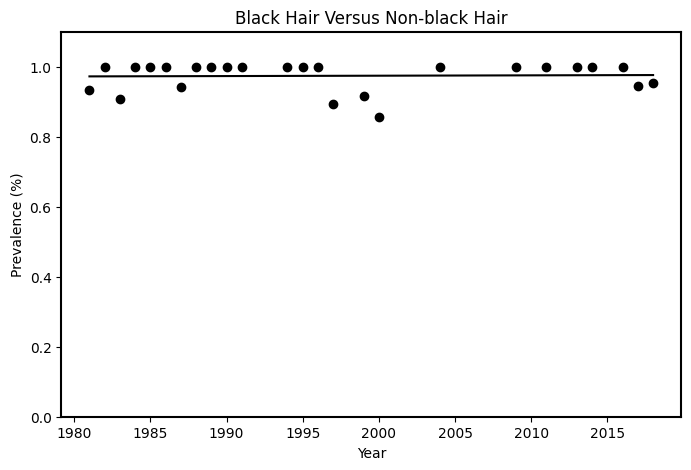

In [22]:
eqn = fit_line("black_hair", "Black Hair Versus Non-black Hair", "Prevalence (%)", 0.1)

### Sigmoidal Model Analysis

Min year: 1975
Max year: 2016 

Min Inc/Prev: 5.197
Max Inc/Prev: 83.308 

Equation: 73.913 / (1 + e^(-1991.411*(x - 0.248))) + 4.659 

H_min: 4.659
H_max: 78.572
Breast Cancer H^2: 0.059



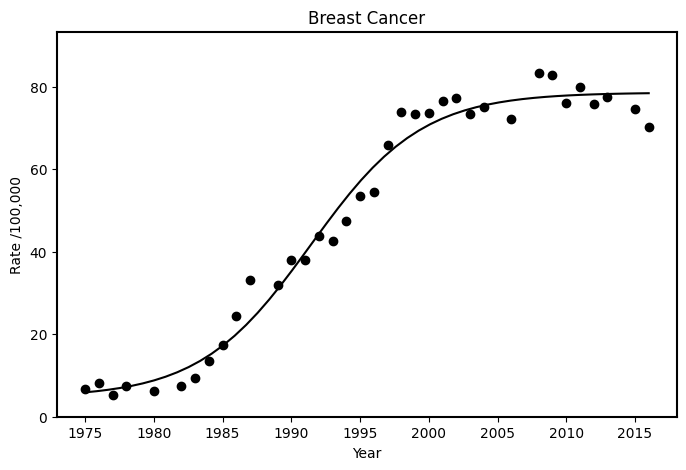

In [23]:
eqn = fit_sigmoid("brC", "Breast Cancer", "Rate /100,000", 10)

#### Segmented-Linear Regression Analysis

Min year: 1966
Max year: 2003 

Min Inc/Prev: 0.144
Max Inc/Prev: 1.470 

H_min: 0.158
H_max: 1.383
Atopic Dermatitis H^2: 0.114



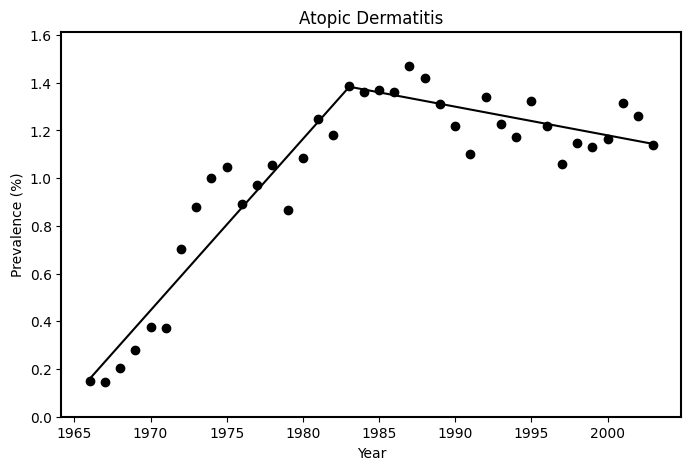

In [24]:
eqn = fit_segmented("atopic_dermatitis", "Atopic Dermatitis", "Prevalence (%)", 0, [1982])

#### Raw Min/Max Calculation and Scatter Plot

Min year: 1950
Max year: 2012 

Min Inc/Prev: 0.000
Max Inc/Prev: 5348.416 

Poliomyelitis H^2: 0.000



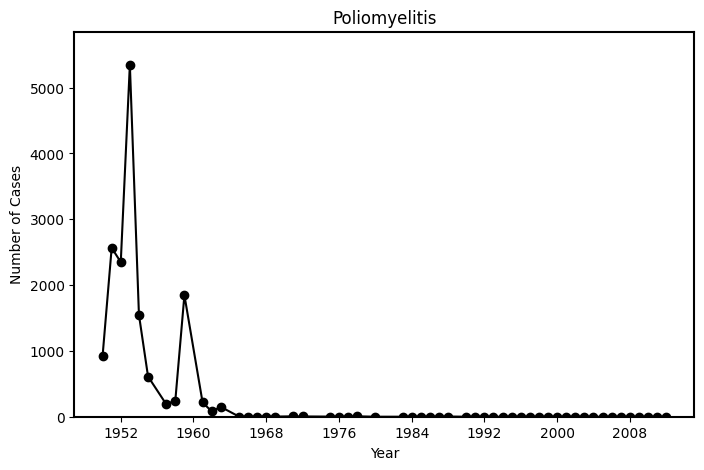

In [25]:
eqn = scatter("polio", "Poliomyelitis", "Number of Cases", 500)

# Calculations used in our paper

The following cells of code below are the exact function calls used to estimate the SHEST Heritability estimates reported in our manuscript "A Novel Approach to Estimate Heritability". Please refer to our manuscript and supporting information for specific information on our method and data selection process.


## Manucript Figures

In [121]:
# --- FIGURE 1
#fit_line("cf", "Linear Model", "Incidence", 10)
#fit_sigmoid("left_handedness_uk", "Sigmoidal Model", "Incidence", 2)
#fit_segmented("atopic_dermatitis", "Segmented Model", "Incidence", 0, [1982])

# --- FIGURE 2
#fit_segmented("atopic_dermatitis", "Atopic Dermatitis", "Prevalence (%)", 0, [1982])
#fit_line("cf", "Cystic Fibrosis", "Incidence /100,000", 10)
#scatter("polio", "Poliomyelitis", "Number of Cases", 500)
#fit_segmented("polio", "Poliomyelitis", "Number of Cases", 1000, [1963])

# --- FIGURE 3
#fit_sigmoid_example("left_handedness_uk", "Sigmoidal Model", "Incidence", 2)
#fit_sigmoid("left_handedness_uk", "Sigmoidal Model", "Incidence", 2)

## Table 1: Genetic

In [16]:
# Black hair
#fit_line("black_hair", "Black Hair Versus Non-black Hair", "Prevalence (%)", 0.1)

# Brown eyes
#fit_line("brown_eyes", "Brown Eyes Versus Non-brown Eyes", "Prevalence (%)", 10)

# CF
#fit_line("cf", "Cystic Fibrosis", "Number of Individuals with CF", 500)

# Down syndrome
#fit_line("down_syndrome", "Down Syndrome", "Rate per 10,000 live births", 3)

# Hereditary heamochromatosis
#fit_line("g_Hereditary_Heam", "Hereditary Heamochromatosis", "Incidence /100,000", 0.5)

# Sex - female
#fit_line("sexF", "Sex (Female)", "Number of Female Sex Births", 15000)

# Sex - male
#fit_line("sexM", "Sex (Male)", "Number of Male Sex Births", 15000)

# Sex - ratio
#fit_line("sex_ratio", "Sex Ratio", "Ratio of female to male sex births", 10)

# SCD
#fit_line("scd", "Sickle Cell Disease", "Percent of Births (%)", 0.01)

## Table 2: Environmental

In [17]:
# COVID 19
#scatter_date_xaxis("covid", "COVID-19", "Number of Cases", 100)

# Diphtheria
#scatter("diph", "Diphtheria", "Number of Cases", 2000)

# HIV
#scatter("hiv_can", "Human Immunodeficiency Virus (HIV)", "Estimated Number of New Cases", 300)

# Measles
#scatter("measles", "Red Measles", "Incidence /1,000,000", 20000)

# Motor vehicle deaths
#fit_segmented("motor_deaths", "Motor Vehicle Deaths", "Incidence /100,000", 5, [1910,1940,1950,1970])

# Syphilis
#scatter("syph", "Syphilis", "Rate /100,000", 1)

# Varicella
#fit_segmented("varc", "Varicella", "Incidence /100,000", 50, [2001])

## Table 3: Environmental

In [18]:
# Mumps
#scatter("mumps", "Mumps", "Incidence /100,000", 1000)

# Peptic ulcers
#scatter("peptic_ulcer", "Peptic Ulcers", "Percent Incidence (%)", 0.5)

# Polio
#scatter("polio", "Poliomyelitis", "Number of Cases", 500)

# Rubella
#scatter("rubella", "Rubella", "Incidence /100,000", 15)

# Tuberculosis
#fit_segmented("TB_canada", "Tuberculosis", "Rate / 100,000", 0, [1950, 1985])

## Table 4: Complex

In [122]:
# --- Alzheumer's Disease
#fit_segmented("alzheimers", "Alzheimer's Disease", "Prevalence (%)", 0, [1992])

# --- Anorexia Nervosa
#fit_line("anorexia2", "Anorexia Nervosa", "Incidence /100,000", 5)
#fit_sigmoid("anorexia", "Anorexia Nervosa", "Incidence /100,000", 0.5) # This data not used in manuscript table 4 but referenced in supporting information

# --- Asthma
#fit_segmented("asthma_2", "Asthma", "Prevalence (%)", 0, [1990])

# --- Atopic Dermatitis
#fit_segmented("atopic_dermatitis", "Atopic Dermatitis", "Prevalence (%)", 0, [1990])

# --- Austism
#fit_segmented("autism", "Autism Spectrum Disorder", "Prevalence (%)", 0.1, [1990])

# --- Bipolar disorder
#fit_segmented("bpd", "Bipolar Disorder", "Incidence /100,000", 0, [2003])

# --- Breast cancer
#eqn = minmax_time("raw_breast_cancer", "Breast Cancer", "Incidence / 100000", "Country", 0) # Do NOT use - keep for geographic
#fit_sigmoid("brC", "Breast Cancer", "Rate /100,000", 10)

# --- Celiac disease
#fit_segmented("celiac", "Celiac Disease", "Incidence / 100000", 0, [1990])

# --- Cervical cancer
#fit_segmented("cervical_cancer_japan", "Cervical Cancer", "Incidence / 100000", 0, [1980,1995])

# --- Esophageal cancer
#fit_line("esophageal_carcinoma", "Esophageal Cancer", "Incidence / 100000", 1)

# --- Graves disease
#fit_segmented("graves_disease", "Graves Disease", "Incidence / 100000", 3, [1987])

# --- Hay fever
#fit_segmented("raw_hay_fever", "Hay Fever", "Prevalence (%)", 0, [1989])

# --- Hypercholesteremia
#fit_segmented("hyperchol", "Hypercholesteremia", "Prevalence (%)", 0, [1983])

# --- Lung cancer
#fit_sigmoid("lung_cancer", "Lung Cancer Mortality", "Incidence / 100000", 10)

# --- Myopia
#fit_segmented("myopia_hk", "Myopia", "Prevalence (%)", 0, [1959,1963,1966])

# --- Obesity
#fit_line("obesity", "Obesity", "Prevalence (%)", 2)

# --- Psoriasis
#fit_line("psoriasis_1", "Psoriasis", "Incidence / 100000", 20)

# --- Rheumatoid arthritis
#fit_line("rheum_arth", "Rheumatoid Arthritis", "Incidence / 1000 Person Years", 0.05)

# --- Stroke
#fit_line("stroke", "Stroke", "Death Rate / 100000 Person Years", 20)

# --- Type I diabetes
#fit_segmented("type_I_diabetes_2", "Type I Diabetes", "Incidence /100,000", 2, [1985])

# --- Type II diabetes
#fit_segmented("DM2", "Type II Diabetes", "Percentage With Diabetes (%)", 1, [1994,2015])

# --- Ulcerative colitis
#fit_segmented("ulcertative_colitis", "Ulcerative Colitis", "Incidence /100000", 0, [1944,1954,1964,1974])


## Table 5: Quantitative

Min year: 1830
Max year: 1960 

Min Inc/Prev: 13.01386
Max Inc/Prev: 16.18707 

Standard Deviation: 0.90 

Age at Menarche H^2: 0.11855



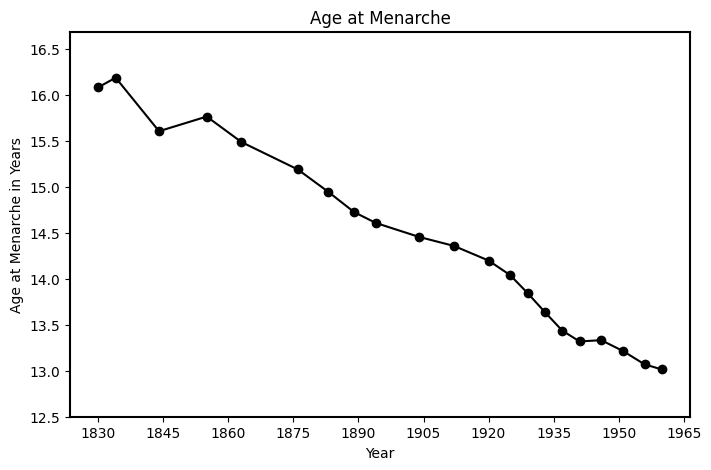

Min year: 1979
Max year: 2006 

Min Inc/Prev: 82.11538
Max Inc/Prev: 86.05769 

Standard Deviation: 1.00 

Diastolic Blood Pressure (DBP) H^2: 0.01442



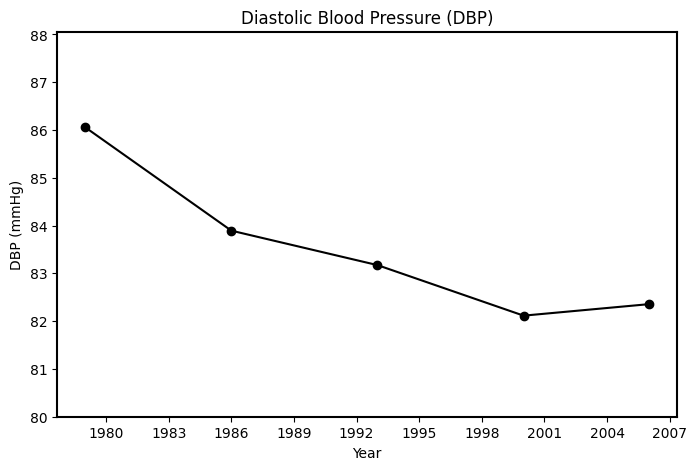

Min year: 1979
Max year: 2007 

Min Inc/Prev: 129.74180
Max Inc/Prev: 134.40852 

Standard Deviation: 1.17 

Systolic Blood Pressure (SBP) H^2: 0.00284



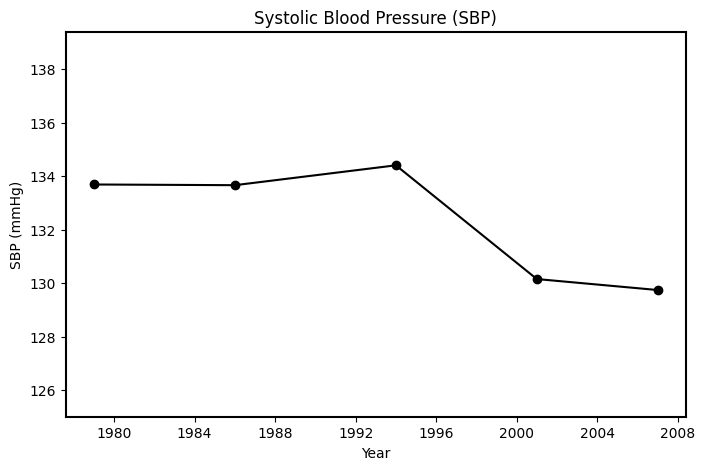

Min year: 1882
Max year: 1986 

Min Inc/Prev: 22.59567
Max Inc/Prev: 31.46209 

Standard Deviation: 2.50 

Body Mass Index (BMI) H^2: 0.11336



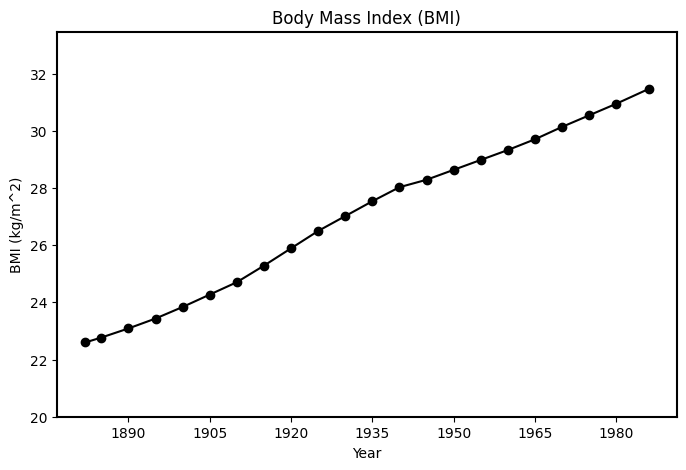

Min year: 1822
Max year: 1997 

Min Inc/Prev: 160.92600
Max Inc/Prev: 183.89800 

Standard Deviation: 7.10 

Height H^2: 0.19113



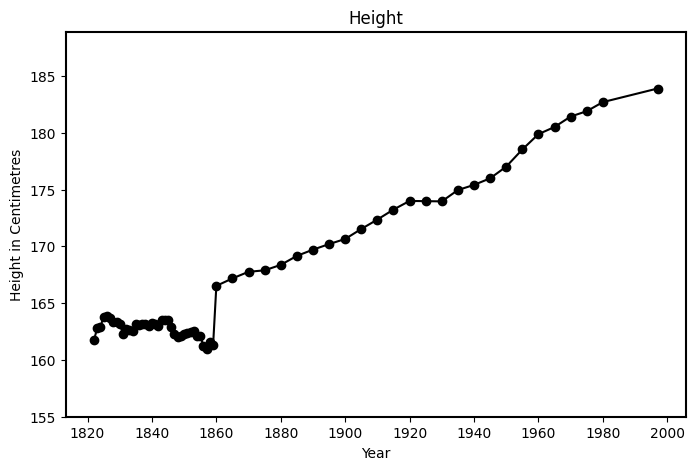

Min year: 1951
Max year: 2013 

Min Inc/Prev: 0.00000
Max Inc/Prev: 36.75000 

Standard Deviation: 15.00 

Intelligence Quotient (IQ) H^2: 0.38750



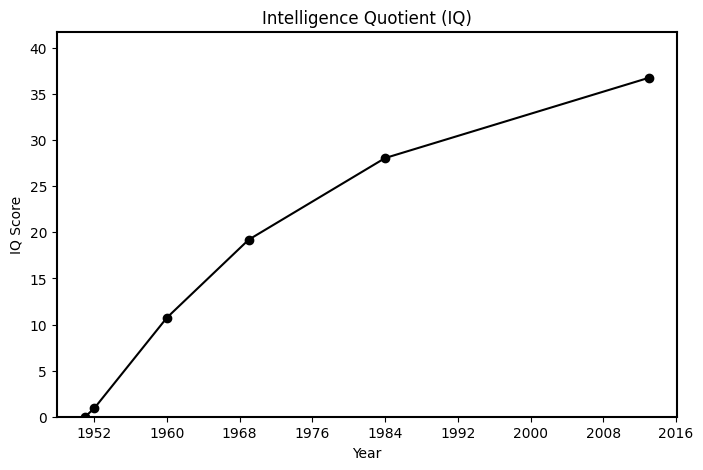

In [73]:
# Standard Deviations to estimate SHEST for quantitative traits.
# Refer to our manuscript for full references.

AAM_SD = 0.9      # Bratke et. al, 2017. Timing of menarche in Norwegian girls: associations with body mass index, waist circumference and skinfold thickness
DBP_SD = 1.0      # Hopstock, 2015. Longitudinal and Secular Trends in Blood Pressure Among Women and Men in Birth Cohorts Born Between 1905 and 1977 The Tromsø Study 1979 to 2008
SBP_SD = 1.17     # Hopstock, 2015. Longitudinal and Secular Trends in Blood Pressure Among Women and Men in Birth Cohorts Born Between 1905 and 1977 The Tromsø Study 1979 to 2008
BMI_SD = 2.5      # Floud, 1998. Height, Weight and Body Mass of the British Population Since 1820
Height_SD = 7.1   # Schonbeck et. al, 2012. The world’s tallest nation has stopped growing taller: the height of Dutch children from 1955 to 2009
IQ_SD = 15.0      # Trahan et. al, 2014. The Flynn Effect: A Meta-analysis

# AAM
scatter_quantitative("aam", "Age at Menarche", "Age at Menarche in Years", 0.5, AAM_SD, 12.5)

# DBP
scatter_quantitative("dbp", "Diastolic Blood Pressure (DBP)", "DBP (mmHg)", 2, DBP_SD, 80)

# SBP
scatter_quantitative("sbp", "Systolic Blood Pressure (SBP)", "SBP (mmHg)", 5, SBP_SD, 125)

# BMI
scatter_quantitative("bmi", "Body Mass Index (BMI)", "BMI (kg/m^2)", 2, BMI_SD, 20)

# Height
scatter_quantitative("height", "Height", "Height in Centimetres", 5, Height_SD, 155)

# IQ
scatter_quantitative("iq", "Intelligence Quotient (IQ)", "IQ Score", 5, IQ_SD, 0)

## Counter Examples

In [70]:
# Beta-thalassemia
#scatter("beta_thal", "Beta thalassemia", "Newborns with Beta-thalassemia", 5)
#fit_line("beta_thal_lin", "Beta thalassemia", "Newborns with Beta-thalassemia", 5)

# Hereditary haemochromatosis
#fit_segmented("Hereditary_Heam", "Hereditary Haemochromatosis", "Incidence / 100,000", 0, [1965])
#fit_line("g_Hereditary_Heam", "Hereditary Heamochromatosis", "Incidence /100,000", 0.5)

# HIV
#fit_line("HIV_1992to2015", "Human Immunodeficiency Virus", "No. of Infections (thousands)", 2000)
#fit_segmented("HIV", "Human Immunodeficiency Virus", "No. of Infections (thousands)", 5, [1980,1998])

# Motor vehicle deaths in the USA
#fit_line("motor_deaths_1930to1980", "Motor Vehicle Deaths (1930 - 1980)", "Incidence / 100,000", 15)
#fit_segmented("motor_deaths", "Motor Vehicle Deaths (1900 - 2010)", "Incidence / 100,000", 5, [1905,1915,1958,1970])

# Ocular Trauma
#fit_line("ocular_trauma", "Ocular Trauma", "Incidence / 100,000", 15)
